In [1]:
import numpy as np
import tensorflow as tf
from enum import Enum
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import interp1d

In [2]:
with open('data/batch1.pkl', 'rb') as f:
    batch1 = np.load(f)
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

with open('data/batch2.pkl', 'rb') as f:
    batch2 = np.load(f)
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
        
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

with open('data/batch3.pkl', 'rb') as f:
    batch3 = np.load(f)
    
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

batch1_size = len(batch1.keys())
batch2_size = len(batch2.keys())
batch3_size = len(batch3.keys())

batch_size = batch1_size + batch2_size + batch3_size

batches = {**batch1, **batch2, **batch3}

del batch1
del batch2
del batch3

In [3]:
test_ind = np.hstack((np.arange(0,(batch1_size+batch2_size),2),83))
train_ind = np.arange(1,(batch1_size+batch2_size-1),2)
secondary_test_ind = np.arange(batch_size-batch3_size,batch_size)

Text(0,0.5,'Discharge Capacity (Ah)')

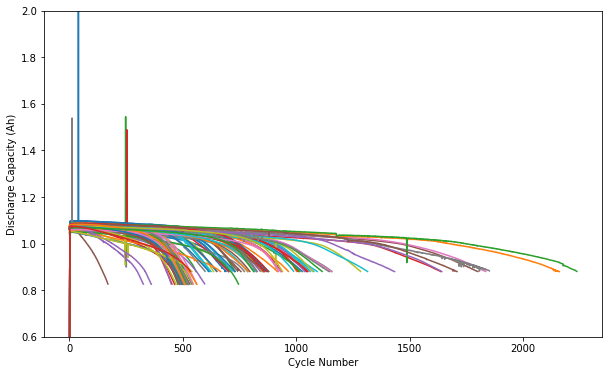

In [4]:
plt.figure(figsize=(10,6))
for i in batches.keys():
    plt.plot(batches[i]['summary']['cycle'], batches[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylim(0.6, 2)
plt.ylabel('Discharge Capacity (Ah)')

In [5]:
print('Cell count: ', len(batches))
print('Cell names: ', batches.keys())

cell = batches['b1c23']

Cell count:  124
Cell names:  dict_keys(['b2c22', 'b3c22', 'b2c44', 'b3c30', 'b1c26', 'b2c39', 'b1c9', 'b2c21', 'b1c23', 'b3c35', 'b1c36', 'b2c13', 'b3c31', 'b2c41', 'b2c18', 'b1c43', 'b1c19', 'b3c34', 'b3c43', 'b3c1', 'b2c5', 'b2c37', 'b2c28', 'b3c4', 'b3c9', 'b1c33', 'b1c17', 'b3c5', 'b3c27', 'b3c10', 'b1c35', 'b3c13', 'b1c21', 'b3c16', 'b1c30', 'b3c45', 'b3c7', 'b1c45', 'b1c5', 'b2c35', 'b1c18', 'b2c20', 'b2c17', 'b1c42', 'b2c38', 'b3c40', 'b3c14', 'b3c21', 'b1c6', 'b1c15', 'b1c37', 'b1c29', 'b1c14', 'b2c26', 'b2c10', 'b2c1', 'b2c36', 'b2c45', 'b2c6', 'b1c38', 'b3c26', 'b1c25', 'b2c11', 'b3c0', 'b1c27', 'b2c40', 'b3c19', 'b3c8', 'b2c33', 'b3c41', 'b1c7', 'b2c23', 'b3c3', 'b2c12', 'b1c3', 'b1c28', 'b2c24', 'b3c24', 'b3c33', 'b2c43', 'b2c19', 'b3c6', 'b1c24', 'b1c41', 'b2c0', 'b3c29', 'b3c12', 'b3c18', 'b2c42', 'b3c17', 'b1c44', 'b1c40', 'b2c47', 'b2c2', 'b2c46', 'b1c34', 'b2c32', 'b2c34', 'b2c4', 'b3c25', 'b1c31', 'b1c1', 'b2c31', 'b3c15', 'b2c3', 'b2c25', 'b2c30', 'b1c0', 'b3c28', '

keys: dict_keys(['QD', 'cycle', 'Tmax', 'chargetime', 'Tavg', 'Tmin', 'QC', 'IR'])
charge time:  1050
V:  1103
Qc:  1103


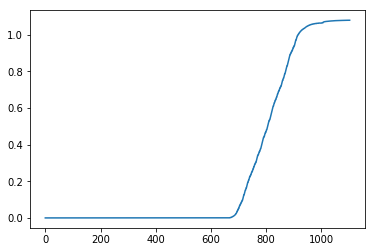

In [6]:
summary = batches['b1c41']['summary']
summary_keys = summary.keys()
print('keys:', summary_keys)

print('charge time: ', len(summary['IR']))
print('V: ', len(cell['cycles']['1']['V']))
print('Qc: ', len(cell['cycles']['1']['Qd']))
plt.plot(cell['cycles']['1']['Qd'], label='QD')



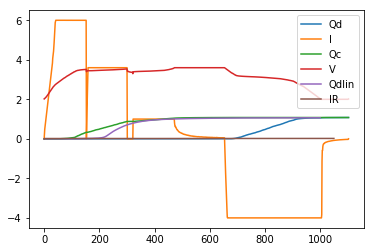

In [7]:
Qd = cell['cycles']['1']['Qd']
I = cell['cycles']['1']['I']
s = slice(len(Qd))


plt.plot(Qd[s], label='Qd')
plt.plot(I[s], label='I')
plt.plot(cell['cycles']['1']['Qc'][s], label='Qc')
plt.plot(cell['cycles']['1']['V'][s], label='V')
plt.plot(cell['cycles']['1']['Qdlin'][s], label='Qdlin')
plt.plot(summary['IR'], label='IR')
plt.legend()

In [8]:
def get_QV(cycle, num=1000):
    V = cycle['V']
    Qd = cycle['Qdlin']
    v = np.linspace(np.max(V), np.min(V), num=len(Qd), endpoint=True)
    return Qd, v

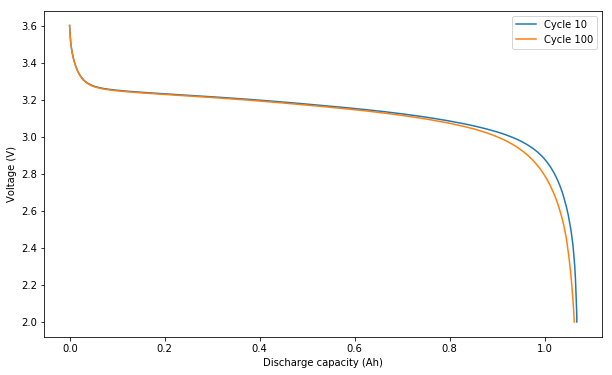

In [9]:
plt.figure(figsize=(10,6))

for cycle in [10, 100]:
    qd, v = get_QV(cell['cycles'][str(cycle)])
    plt.plot(qd, v, label='Cycle {}'.format(cycle))
    plt.xlabel('Discharge capacity (Ah)')
    plt.ylabel('Voltage (V)')
plt.legend()

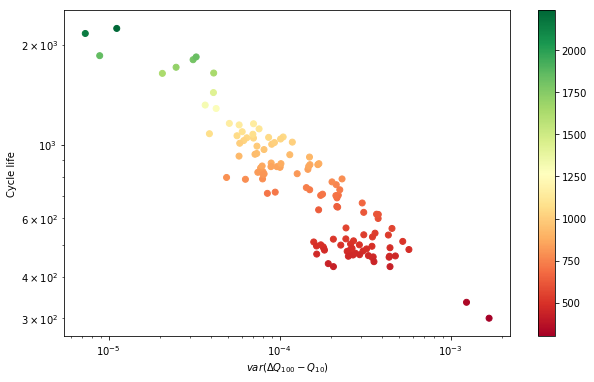

p corr:  -0.9086330297856694


In [10]:
xs, ys = [], []

fig = plt.figure(figsize=(10,6))

for cell in batches.values():
    qv10, v = get_QV(cell['cycles'][str(10)])
    qv100, v = get_QV(cell['cycles'][str(100)])
    var = np.var(qv100 - qv10)

    xs.append(var)
    ys.append(cell['cycle_life'][:])

    
worst_battery = np.argmax(xs)
del xs[worst_battery]
del ys[worst_battery]

xs = np.array(xs).reshape(-1, 1)
ys = np.array(ys).reshape(-1, 1)

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

cm = plt.cm.get_cmap('RdYlGn')

sc = plt.scatter(xs, ys, c=ys, cmap=cm)
    
plt.colorbar(sc)
plt.ylabel('Cycle life')
plt.xlabel(r'$var(\Delta Q_{100} - Q_{10})$')
plt.show()

xs = np.array(xs).reshape(-1)
ys = np.array(ys).reshape(-1)
print('p corr: ', np.corrcoef(np.log(xs), np.log(ys))[0,1])



In [11]:
# How many cycles to look at?
n_cycles = 100
n_inputs = 1000

N_EPOCHS = 100
cycle_life_boundary = 550

In [12]:
class ModelType(Enum):
    VARIANCE = 0
    DISCHARGE = 1
    FULL = 2

# Classification

In [13]:
from sklearn.preprocessing import MinMaxScaler

def get_classifier_dataset(d, model_type, n_cycles, n_inputs, cycle_life_boundary):
    
    if model_type == ModelType.DISCHARGE:
        keys = ['Qd']
        n_features = len(keys)
    elif model_type == ModelType.FULL:
        keys = next(iter(d.values()))['cycles']['0'].keys()
        n_features = len(keys)
    else:
        n_features = 1

    cycle_lives = [cell['cycle_life'].flatten() for cell in d.values()]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(cycle_lives)
    data = None
    variances = np.empty(shape=(len(d), 1))
    for idx, (name, cell) in enumerate(d.items()):
        
        if model_type == ModelType.VARIANCE:
            features = np.empty(shape=(1,), dtype=np.float32)
        else:
            features = np.zeros(shape=(n_cycles, n_features, n_inputs))
            for i in range(n_cycles):
                cycle = cell['cycles'][str(i+1)]
                for j, key in enumerate(keys):
                    
                    q, v = get_QV(cycle, n_inputs)
                    features[i,j,:] = q
                    
        qd5, v = get_QV(cell['cycles'][str(5)])
        qd4, v = get_QV(cell['cycles'][str(4)])
        q_var = np.array([np.log(np.var(qd5 - qd4))])

        features = features.flatten()
        x = np.hstack([q_var, features])
        cycle_life = cell['cycle_life']
        y = 1.0 if cycle_life > cycle_life_boundary else 0.0
        y = np.array([y])
        xy = (q_var, y, cycle_life),
        if data is None:
            data = xy
        else:
            data = np.vstack([data, xy])
    return data, scaler

model_type = ModelType.VARIANCE
data, scaler = get_classifier_dataset(batches, model_type, n_cycles, n_inputs, cycle_life_boundary)

data_train = data[train_ind]
data_val = data[test_ind]
data_test = data[secondary_test_ind]

print(data_train[0:2])

x_train, y_train, cycle_life_train = [data_train[:,i] for i in range(3)]
x_test, y_test, cycle_life_test = [data_test[:,i] for i in range(3)]
x_val, y_val, cycle_life_val = [data_val[:,i] for i in range(3)]

[[[-1.74311764e+01]
  [ 1.00000000e+00]
  [ 1.00200000e+03]]

 [[-1.53389593e+01]
  [ 1.00000000e+00]
  [ 9.35000000e+02]]]


In [14]:
inputs = tf.keras.Input(shape=(1,))
x = Dense(32, activation='relu')(inputs)
outputs = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
lr = 1e-1
optimizer = tf.keras.optimizers.Adam(lr=lr, decay=lr/N_EPOCHS) 
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=len(x_train), epochs=N_EPOCHS,
          validation_data=(x_val, y_val))

ev = model.evaluate(x_test, y_test, verbose=0)

Train on 41 samples, validate on 43 samples
Epoch 1/100
41/41 [==============================] - 0s 7ms/sample - loss: 0.8744 - accuracy: 0.6585 - val_loss: 2.4577 - val_accuracy: 0.3023
Epoch 2/100
41/41 [==============================] - 0s 98us/sample - loss: 2.3854 - accuracy: 0.3415 - val_loss: 1.0061 - val_accuracy: 0.3023
Epoch 3/100
41/41 [==============================] - 0s 95us/sample - loss: 0.9819 - accuracy: 0.3415 - val_loss: 0.5948 - val_accuracy: 0.6977
Epoch 4/100
41/41 [==============================] - 0s 120us/sample - loss: 0.6413 - accuracy: 0.6585 - val_loss: 0.7542 - val_accuracy: 0.6977
Epoch 5/100
41/41 [==============================] - 0s 88us/sample - loss: 0.8419 - accuracy: 0.6585 - val_loss: 0.7727 - val_accuracy: 0.6977
Epoch 6/100
41/41 [==============================] - 0s 96us/sample - loss: 0.8639 - accuracy: 0.6585 - val_loss: 0.7013 - val_accuracy: 0.6977
Epoch 7/100
41/41 [==============================] - 0s 86us/sample - loss: 0.7782 - accurac

Epoch 58/100
41/41 [==============================] - 0s 93us/sample - loss: 0.5732 - accuracy: 0.6585 - val_loss: 0.5506 - val_accuracy: 0.6977
Epoch 59/100
41/41 [==============================] - 0s 87us/sample - loss: 0.5703 - accuracy: 0.6585 - val_loss: 0.5501 - val_accuracy: 0.6977
Epoch 60/100
41/41 [==============================] - 0s 97us/sample - loss: 0.5674 - accuracy: 0.6585 - val_loss: 0.5501 - val_accuracy: 0.6977
Epoch 61/100
41/41 [==============================] - 0s 90us/sample - loss: 0.5650 - accuracy: 0.6585 - val_loss: 0.5501 - val_accuracy: 0.6977
Epoch 62/100
41/41 [==============================] - 0s 100us/sample - loss: 0.5628 - accuracy: 0.6585 - val_loss: 0.5489 - val_accuracy: 0.6977
Epoch 63/100
41/41 [==============================] - 0s 104us/sample - loss: 0.5604 - accuracy: 0.6585 - val_loss: 0.5462 - val_accuracy: 0.6977
Epoch 64/100
41/41 [==============================] - 0s 106us/sample - loss: 0.5573 - accuracy: 0.6585 - val_loss: 0.5422 - val

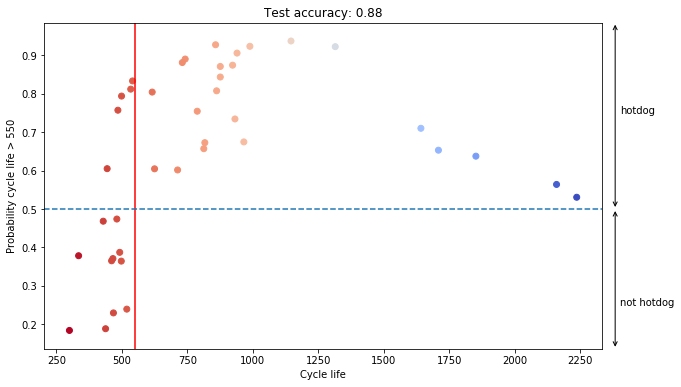

In [15]:
plt.figure(figsize=(10,6))
pred = model.predict(x_test)
sc = plt.scatter(cycle_life_test, pred, c=-cycle_life_test, cmap='coolwarm')
ax = plt.gca()
plt.axvline(cycle_life_boundary, c='r')
plt.axhline(0.5, linestyle='--')
plt.ylabel('Probability cycle life > {}'.format(cycle_life_boundary))
plt.xlabel('Cycle life')

plt.title('Test accuracy: {:.2f}'.format(ev[-1]))

maxx = plt.axis()[1] + 50
miny = plt.axis()[-2]
maxy = plt.axis()[-1]

plt.annotate(
    '', xy=(maxx, 0.5),
    xytext=(maxx, maxy),
    arrowprops={'arrowstyle': '<->'}, annotation_clip=False)

plt.annotate(
    'hotdog', xy=(maxx, 0.75), xycoords='data',
    xytext=(5, 0), textcoords='offset points',
    annotation_clip=False)

plt.annotate(
    '', xy=(maxx, miny),
    xytext=(maxx, 0.5),
    arrowprops={'arrowstyle': '<->'},
    annotation_clip=False)

plt.annotate(
    'not hotdog', xy=(maxx, 0.25), xycoords='data',
    xytext=(5, 0), textcoords='offset points',
    annotation_clip=False)

plt.show()